<a href="https://colab.research.google.com/github/shelby457/DS_Java_Galgotias/blob/main/ipl_score_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IPL Score Predictor using Machine Learning

This project predicts the final score of an IPL team using ball-by-ball match data.
We use two machine learning algorithms:
1. Linear Regression
2. Random Forest Regression

The model is trained on over-wise features generated from ball-by-ball data.


In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
# Upload Dataset
from google.colab import files
uploaded = files.upload()


Saving ipl_ball_by_ball.csv to ipl_ball_by_ball (1).csv


In [4]:
# Load Dataset
df = pd.read_csv(list(uploaded.keys())[0])
print(df.head())
print(df.shape)


/tmp/ipython-input-1561104827.py:2: DtypeWarning: Columns (28,29,30,31,43,46,47,48,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(list(uploaded.keys())[0])


   Unnamed: 0  match_id        date match_type             event_name  \
0      131970    335982  2008-04-18        T20  Indian Premier League   
1      131971    335982  2008-04-18        T20  Indian Premier League   
2      131972    335982  2008-04-18        T20  Indian Premier League   
3      131973    335982  2008-04-18        T20  Indian Premier League   
4      131974    335982  2008-04-18        T20  Indian Premier League   

   innings           batting_team                 bowling_team  over  ball  \
0        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     1   
1        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     2   
2        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     3   
3        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     3   
4        1  Kolkata Knight Riders  Royal Challengers Bangalore     0     4   

   ...  team_runs team_balls  team_wicket  new_batter  batter_runs  \
0  ...          1     

In [5]:
# Filter First Innings
df = df[df['innings'] == 1]


In [6]:
# Create Wicket Column
df['wicket'] = df['player_out'].apply(lambda x: 0 if pd.isna(x) else 1)


In [7]:
# Convert Ball-by-Ball → Over-Wise Data
over_df = df.groupby(
    ['match_id', 'over', 'batting_team', 'bowling_team']
).agg(
    runs=('runs_total', 'sum'),
    wickets=('wicket', 'sum')
).reset_index()


In [8]:
# Cumulative Runs & Wickets
over_df['current_runs'] = over_df.groupby('match_id')['runs'].cumsum()
over_df['current_wickets'] = over_df.groupby('match_id')['wickets'].cumsum()


In [9]:
# Last 5 Overs Features
over_df['runs_last_5'] = (
    over_df.groupby('match_id')['runs']
    .rolling(5).sum().reset_index(level=0, drop=True)
)

over_df['wickets_last_5'] = (
    over_df.groupby('match_id')['wickets']
    .rolling(5).sum().reset_index(level=0, drop=True)
)

over_df.fillna(0, inplace=True)


In [10]:
# Final Score (Target Variable)
final_score = over_df.groupby('match_id')['current_runs'].max().reset_index()
final_score.rename(columns={'current_runs': 'total_score'}, inplace=True)

final_df = over_df.merge(final_score, on='match_id')


In [11]:
# Final Dataset for ML
model_df = final_df[[
    'batting_team',
    'bowling_team',
    'over',
    'current_runs',
    'current_wickets',
    'runs_last_5',
    'wickets_last_5',
    'total_score'
]]

model_df.head()


,batting_team,bowling_team,over,current_runs,current_wickets,runs_last_5,wickets_last_5,total_score
0,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,0,0.0,0.0,222
1,Kolkata Knight Riders,Royal Challengers Bangalore,1,21,0,0.0,0.0,222
2,Kolkata Knight Riders,Royal Challengers Bangalore,2,27,0,0.0,0.0,222
3,Kolkata Knight Riders,Royal Challengers Bangalore,3,50,0,0.0,0.0,222
4,Kolkata Knight Riders,Royal Challengers Bangalore,4,60,0,60.0,0.0,222


In [12]:
# Encode Categorical Data
le = LabelEncoder()
model_df['batting_team'] = le.fit_transform(model_df['batting_team'])
model_df['bowling_team'] = le.fit_transform(model_df['bowling_team'])


/tmp/ipython-input-2499513583.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['batting_team'] = le.fit_transform(model_df['batting_team'])
/tmp/ipython-input-2499513583.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['bowling_team'] = le.fit_transform(model_df['bowling_team'])


In [13]:
# Train-Test Split
X = model_df.drop('total_score', axis=1)
y = model_df['total_score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [14]:
# ALGORITHM 1: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

print("Linear Regression MAE:", mean_absolute_error(y_test, lr_pred))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, lr_pred)))


Linear Regression MAE: 16.00178338643369
Linear Regression RMSE: 21.677153637955268


In [15]:
# ALGORITHM 2: Random Forest Regression
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print("Random Forest MAE:", mean_absolute_error(y_test, rf_pred))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_pred)))


Random Forest MAE: 15.37870172096532
Random Forest RMSE: 21.423712213404617


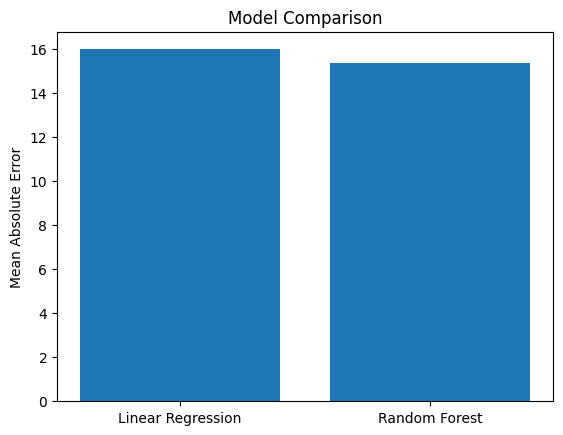

In [16]:
# Model Comparison Graph
models = ['Linear Regression', 'Random Forest']
mae = [
    mean_absolute_error(y_test, lr_pred),
    mean_absolute_error(y_test, rf_pred)
]

plt.bar(models, mae)
plt.ylabel("Mean Absolute Error")
plt.title("Model Comparison")
plt.show()


In [17]:
# Sample Prediction
sample_input = X_test.iloc[0:1]
predicted_score = rf.predict(sample_input)

print("Predicted Score:", int(predicted_score[0]))
print("Actual Score:", int(y_test.iloc[0]))


Predicted Score: 159
Actual Score: 207


## Conclusion

- IPL final scores can be predicted using machine learning.
- Random Forest performs better than Linear Regression.
- Feature engineering from ball-by-ball data improves accuracy.

Future work includes using deep learning and real-time prediction.
